In [19]:
import torch
from torch.optim import SGD, Adam
import torch.nn as nn


from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split


import matplotlib.pyplot as plt
import numpy as np

In [20]:
INPUT_DIMENSION=10
OUTPUT_DIMENSION=1
NUMBER_OF_SAMPLES=1000
EPOCHS=20
LR=0.01

In [21]:
X,y=make_blobs(n_samples=1000, n_features=INPUT_DIMENSION, centers=2, random_state=1)

# Make the categories +/-1 rather thn 0,1
y=2*y-1 

# Transform the entries to have norm less than or equal to 1
X=X/max([np.linalg.norm(x) for x in X]) 

# Split data into train and test
(trainX, testX, trainY, testY) = train_test_split(X, y,test_size=0.15)
trainX = torch.from_numpy(trainX).float()
testX = torch.from_numpy(testX).float()
trainY = torch.from_numpy(trainY).float()
testY = torch.from_numpy(testY).float()

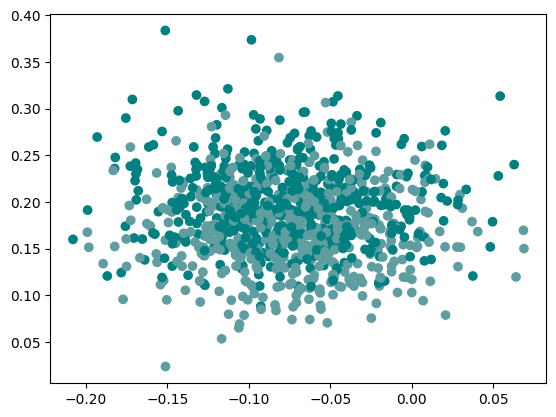

In [22]:
colors=np.full(len(y), 'cadetblue')
colors[y==-1]='teal'
plt.scatter(X[:,0],X[:,1],c=colors)

In [23]:
class LinearClassifier(torch.nn.Module):
  def __init__(self):
    super(LinearClassifier, self).__init__()
    self.linear = torch.nn.Linear(in_features=INPUT_DIMENSION, out_features=OUTPUT_DIMENSION, bias=False)

  def forward(self, x):
    x = self.linear(x)
    return x

In [24]:
def next_batch(inputs, targets, batchSize):
	for i in range(0, inputs.shape[0], batchSize):
		yield (inputs[i:i + batchSize], targets[i:i + batchSize])

In [25]:
model=LinearClassifier()

In [26]:
model.linear.weight=torch.nn.Parameter(torch.from_numpy(np.random.random(INPUT_DIMENSION)).float())

In [27]:
# Train the model

opt = Adam(model.parameters(), lr=LR)
lossFunc = nn.L1Loss()

for epoch in range(0, EPOCHS):
	trainLoss = 0
	trainAcc = 0
	samples = 0
	model.train()
	for (batchX, batchY) in next_batch(trainX, trainY, 6):
		predictions = model(batchX)
		loss = lossFunc(predictions.view(-1), batchY)
		opt.zero_grad()
		loss.backward()
		opt.step()
		trainLoss += loss.item() * len(batchY)
		trainAcc += (torch.sign(predictions) == batchY).sum().item()
		samples += len(batchY)
	print("Epoch: {} Train Loss: {:.3f} Train Accuracy: {:.3f}".format(epoch+1,trainLoss / samples,trainAcc / samples))

Epoch: 1 Train Loss: 0.242 Train Accuracy: 0.953
Epoch: 2 Train Loss: 0.098 Train Accuracy: 1.000
Epoch: 3 Train Loss: 0.093 Train Accuracy: 1.000
Epoch: 4 Train Loss: 0.090 Train Accuracy: 1.000
Epoch: 5 Train Loss: 0.088 Train Accuracy: 1.000
Epoch: 6 Train Loss: 0.087 Train Accuracy: 1.000
Epoch: 7 Train Loss: 0.086 Train Accuracy: 1.000
Epoch: 8 Train Loss: 0.085 Train Accuracy: 1.000
Epoch: 9 Train Loss: 0.085 Train Accuracy: 1.000
Epoch: 10 Train Loss: 0.085 Train Accuracy: 1.000
Epoch: 11 Train Loss: 0.084 Train Accuracy: 1.000
Epoch: 12 Train Loss: 0.084 Train Accuracy: 1.000
Epoch: 13 Train Loss: 0.084 Train Accuracy: 1.000
Epoch: 14 Train Loss: 0.083 Train Accuracy: 1.000
Epoch: 15 Train Loss: 0.083 Train Accuracy: 1.000
Epoch: 16 Train Loss: 0.083 Train Accuracy: 1.000
Epoch: 17 Train Loss: 0.084 Train Accuracy: 1.000
Epoch: 18 Train Loss: 0.084 Train Accuracy: 1.000
Epoch: 19 Train Loss: 0.084 Train Accuracy: 1.000
Epoch: 20 Train Loss: 0.083 Train Accuracy: 1.000


In [28]:
# Normalizing the decision vector

for param in model.parameters():
    decision_vector=param.tolist()
    decision_vector=decision_vector/np.linalg.norm(decision_vector)
model.linear.weight=torch.nn.Parameter(torch.from_numpy(decision_vector).float())

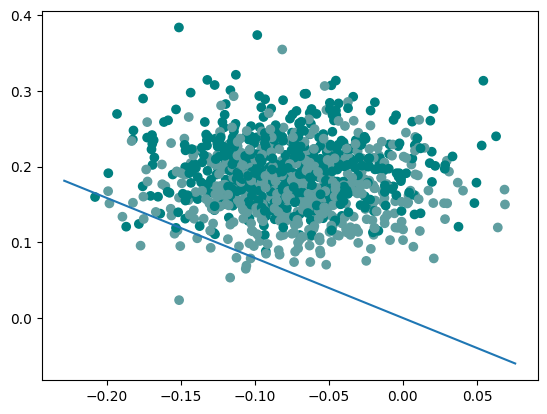

In [29]:
# Decision boundary projected onto first two coordinates

x=np.array([min(X[:,0])*1.1,max(X[:,0])*1.1])
grad=decision_vector[1]/decision_vector[0]
plt.plot(x,-x/grad)
plt.scatter(X[:,0],X[:,1],c=colors)

In [30]:
# Calculating the margin of the classifier

with torch.no_grad():
    for batchX, batchY in next_batch(testX, testY, len(testX)):
        predictions = model(batchX)
        margin=min(abs(predictions)).tolist()
print(margin)

0.3401781916618347


In [31]:
# Compressing the decision as per the algorithm

eta=0.25

compressed_decision_vector=np.zeros(len(decision_vector))
for k, comp in enumerate(decision_vector):
    p=8*comp**2/(eta*margin**2)
    if np.random.random()<p:
        compressed_decision_vector[k]=comp/p

In [32]:
print('Original Classifier: {}'.format(decision_vector))
print('Compressed Classifier: {}'.format(compressed_decision_vector))
print('Rate of compression: {}%'.format(100*sum(compressed_decision_vector==0)/len(decision_vector)))

Original Classifier: [-0.03508543 -0.04425445  0.16433848  0.53489539 -0.08032773  0.56375741
  0.21216622  0.24705202 -0.25049006 -0.43660153]
Compressed Classifier: [ 0.         -0.08171579  0.02200512  0.00676074 -0.04501917  0.00641462
  0.0170446   0.01463776 -0.01443685 -0.00828281]
Rate of compression: 10.0%


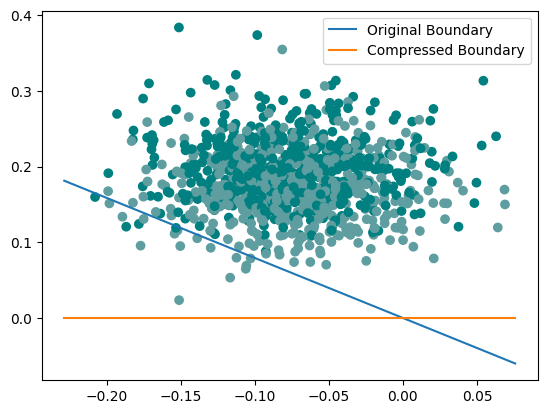

In [33]:
# Compressed decision boundary projected onto first two coordinates

plt.plot(x,-x/grad,label='Original Boundary')
if compressed_decision_vector[0]!=0:
    compressed_grad=compressed_decision_vector[1]/compressed_decision_vector[0]
    plt.plot(x,-x/compressed_grad,label='Compressed Boundary')
else:
    plt.plot(x,-x*0,label='Compressed Boundary')
plt.scatter(X[:,0],X[:,1],c=colors)
plt.legend()

In [34]:
# Creating new model with compressed classifier

compressed_model=LinearClassifier()
compressed_model.linear.weight=torch.nn.Parameter(torch.from_numpy(compressed_decision_vector).float())

In [35]:
original_testAcc=0
samples=0
with torch.no_grad():
    for (batchX, batchY) in next_batch(testX, testY, 1):
        predictions = model(batchX)
        original_testAcc += (torch.sign(predictions) == batchY).sum().item()
        samples += batchY.size(0)
original_testError=original_testAcc/samples

compressed_testAcc=0
samples=0
with torch.no_grad():
    for (batchX, batchY) in next_batch(testX, testY, 1):
        predictions = compressed_model(batchX)
        compressed_testAcc += (torch.sign(predictions) == batchY).sum().item()
        samples += batchY.size(0)
compressed_testError=compressed_testAcc/samples
print('Original Model Test Error: {} Compressed Model Test Error: {}'.format(original_testError,compressed_testError))

Original Model Test Error: 1.0 Compressed Model Test Error: 0.9933333333333333
